# 1. Load Packages

In [1]:
import os, sys
sys.path.append('analysis-tools')
from analysis_tools.common.utils import *
from analysis_tools import utils, random, eda

# 2. Load and Look over dataset

In [2]:
train = pd.read_csv('../../data/train_data.csv')
test = train.query('Day >= 199')
train = train.query('Day < 199')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3820608 entries, 0 to 3858911
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 408.1+ MB


In [4]:
train.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36


In [5]:
## check missing value
train.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45556
Wdir       45556
Etmp       45556
Itmp       45556
Ndir       45556
Pab1       45556
Pab2       45556
Pab3       45556
Prtv       45556
Patv       45556
dtype: int64

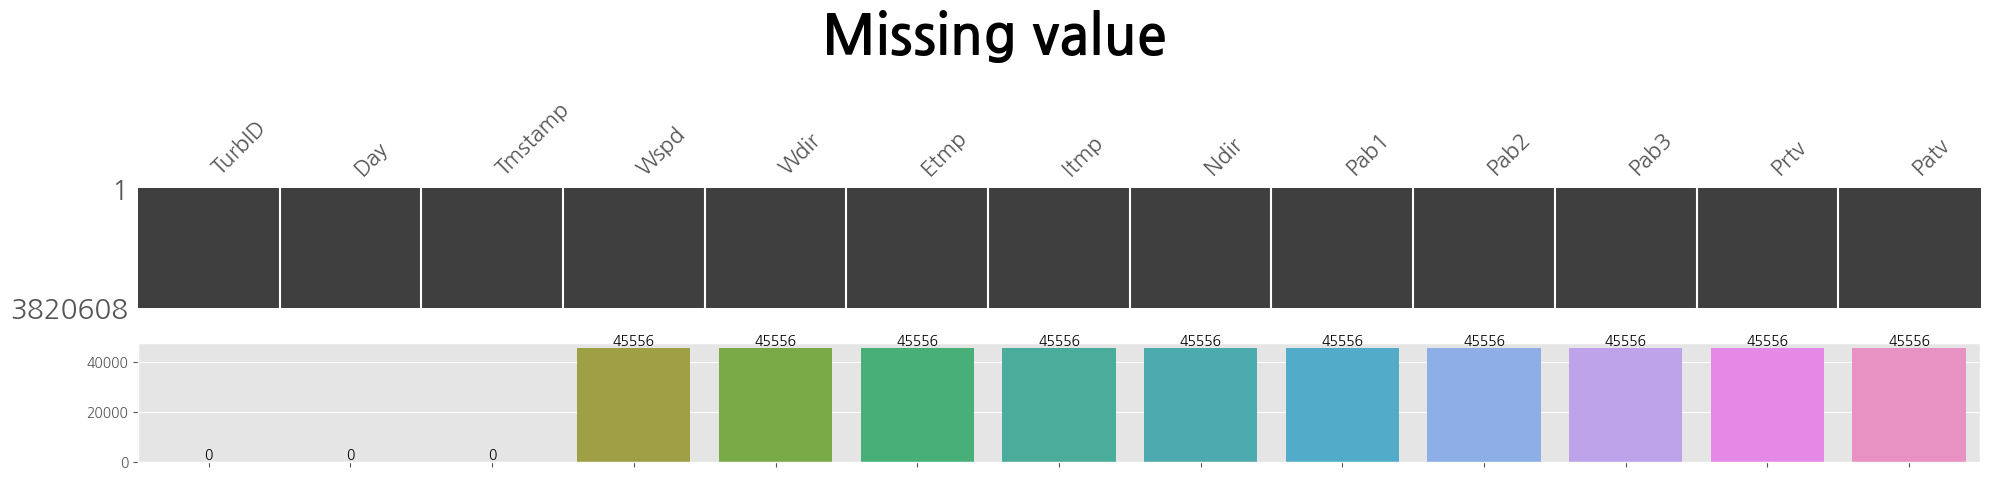

In [6]:
import matplotlib as mpl
plt.rcParams["font.family"] = "NanumGothic"
mpl.rcParams['axes.unicode_minus'] = False
eda.plot_missing_value(train, figsize=(20, 5))

- TurbID : Wind turbine ID, 발전기 ID (1~134)
<br></br>
- Day : Day of the record, 날짜 (1~200)
<br></br>
- Tmstamp(HH:MM) : Created time of the record, 시간 (00:00 ~ 23:50)
<br></br>
- Wspd(m/s) : The wind speed recorded by the anemometer, 풍속
<br></br>
- Wdir(°) : wind direction, 터빈이 바라보는 각도와 실제 바람 방향 각도 차이
<br></br>
- Etmp(℃) : Temperature of the surounding environment, 외부 온도
<br></br>
- Itmp(℃) : Temperature inside the turbine nacelle, 터빈 내부 온도
<br></br>
- Ndir(°) : Nacelle direction, i.e., the yaw angle of the nacelle, 터빈이 바라보는방향 각도
<br></br>
- Pab(°) : Pitch angle of blade,터빈 당 3개의 날이 있으며 각각의 각도가 다름
<br></br>
- Prtv(kW) : Reactive power, 무효전력(에너지원을 필요로 하지 않는 전력)
<br></br>
- **Patv(kW)** : Active power, 유효전력(실제로 터빈을 돌리는 일을 하는 전력)

# 3. Feature distribution

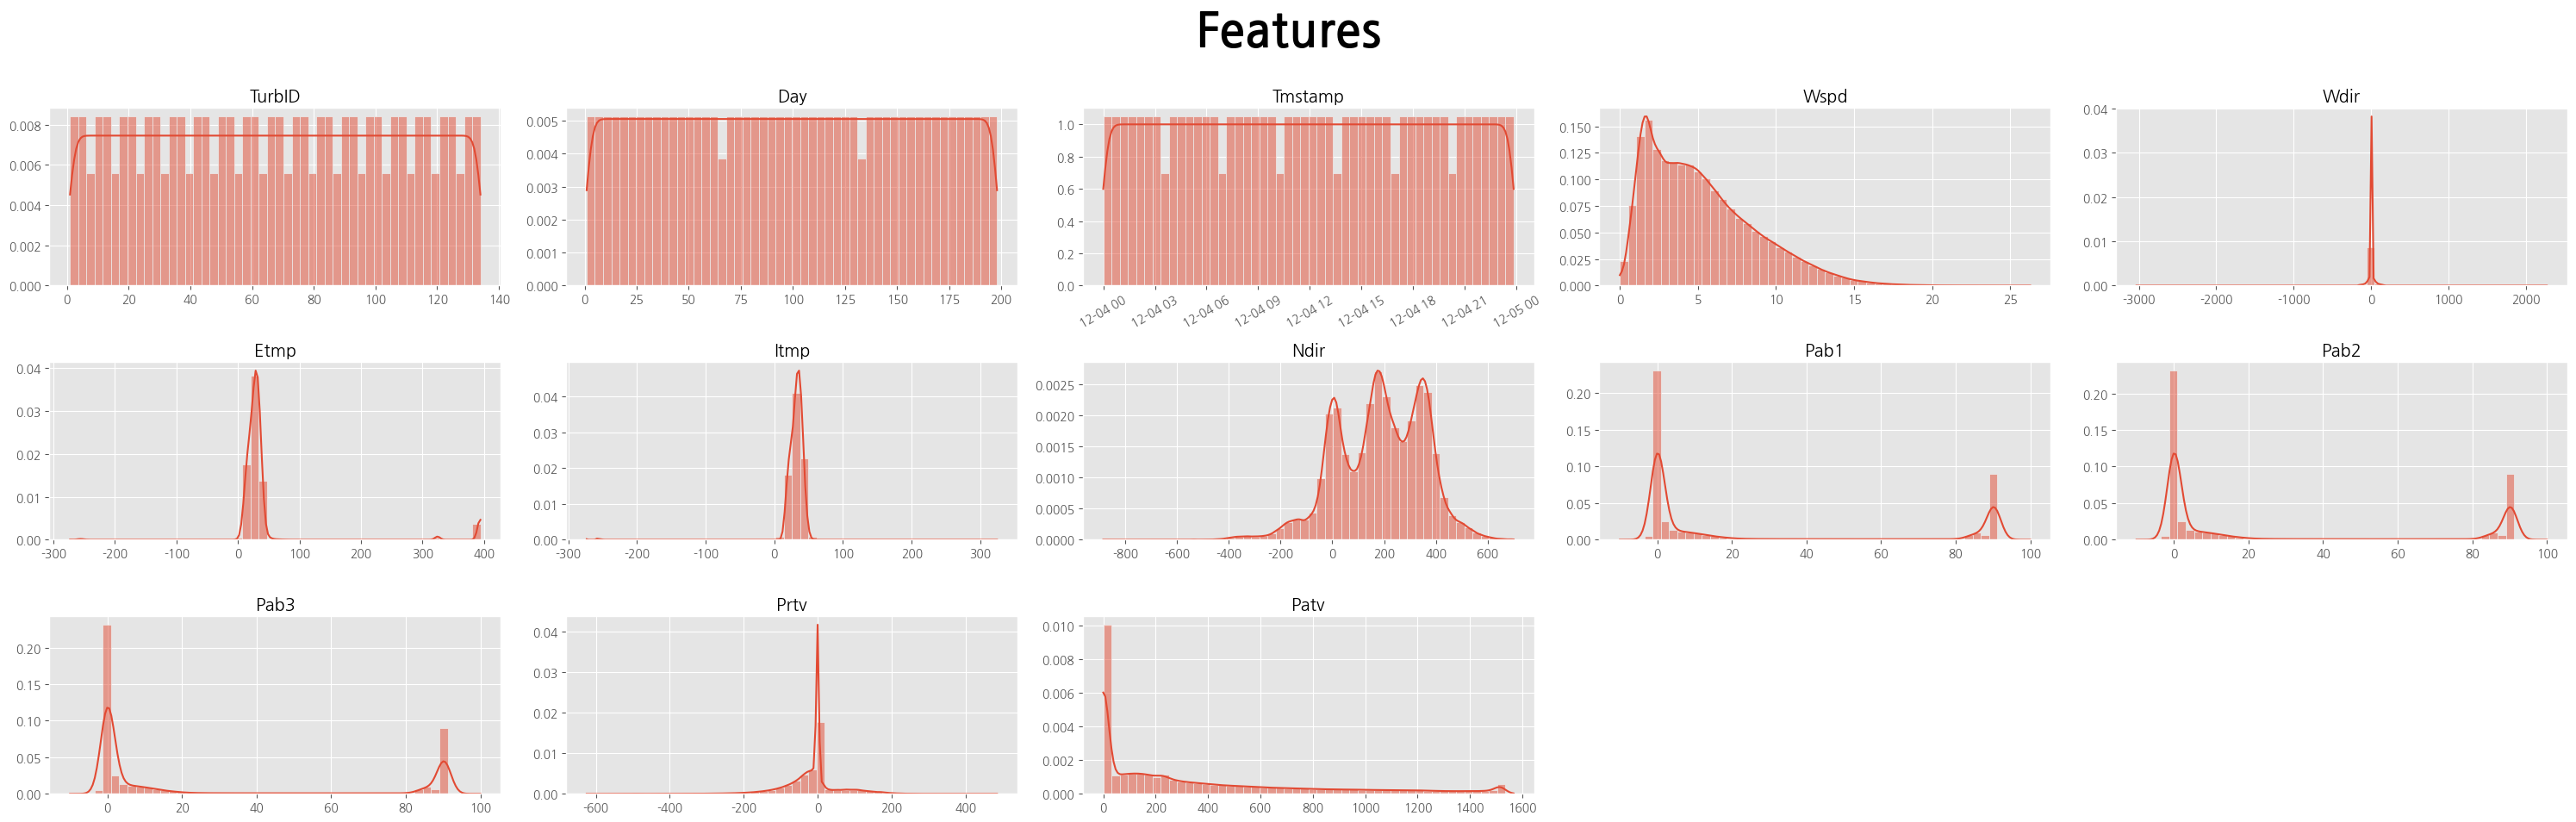

In [7]:
eda.plot_features(train)

# 4. Feature vs Target

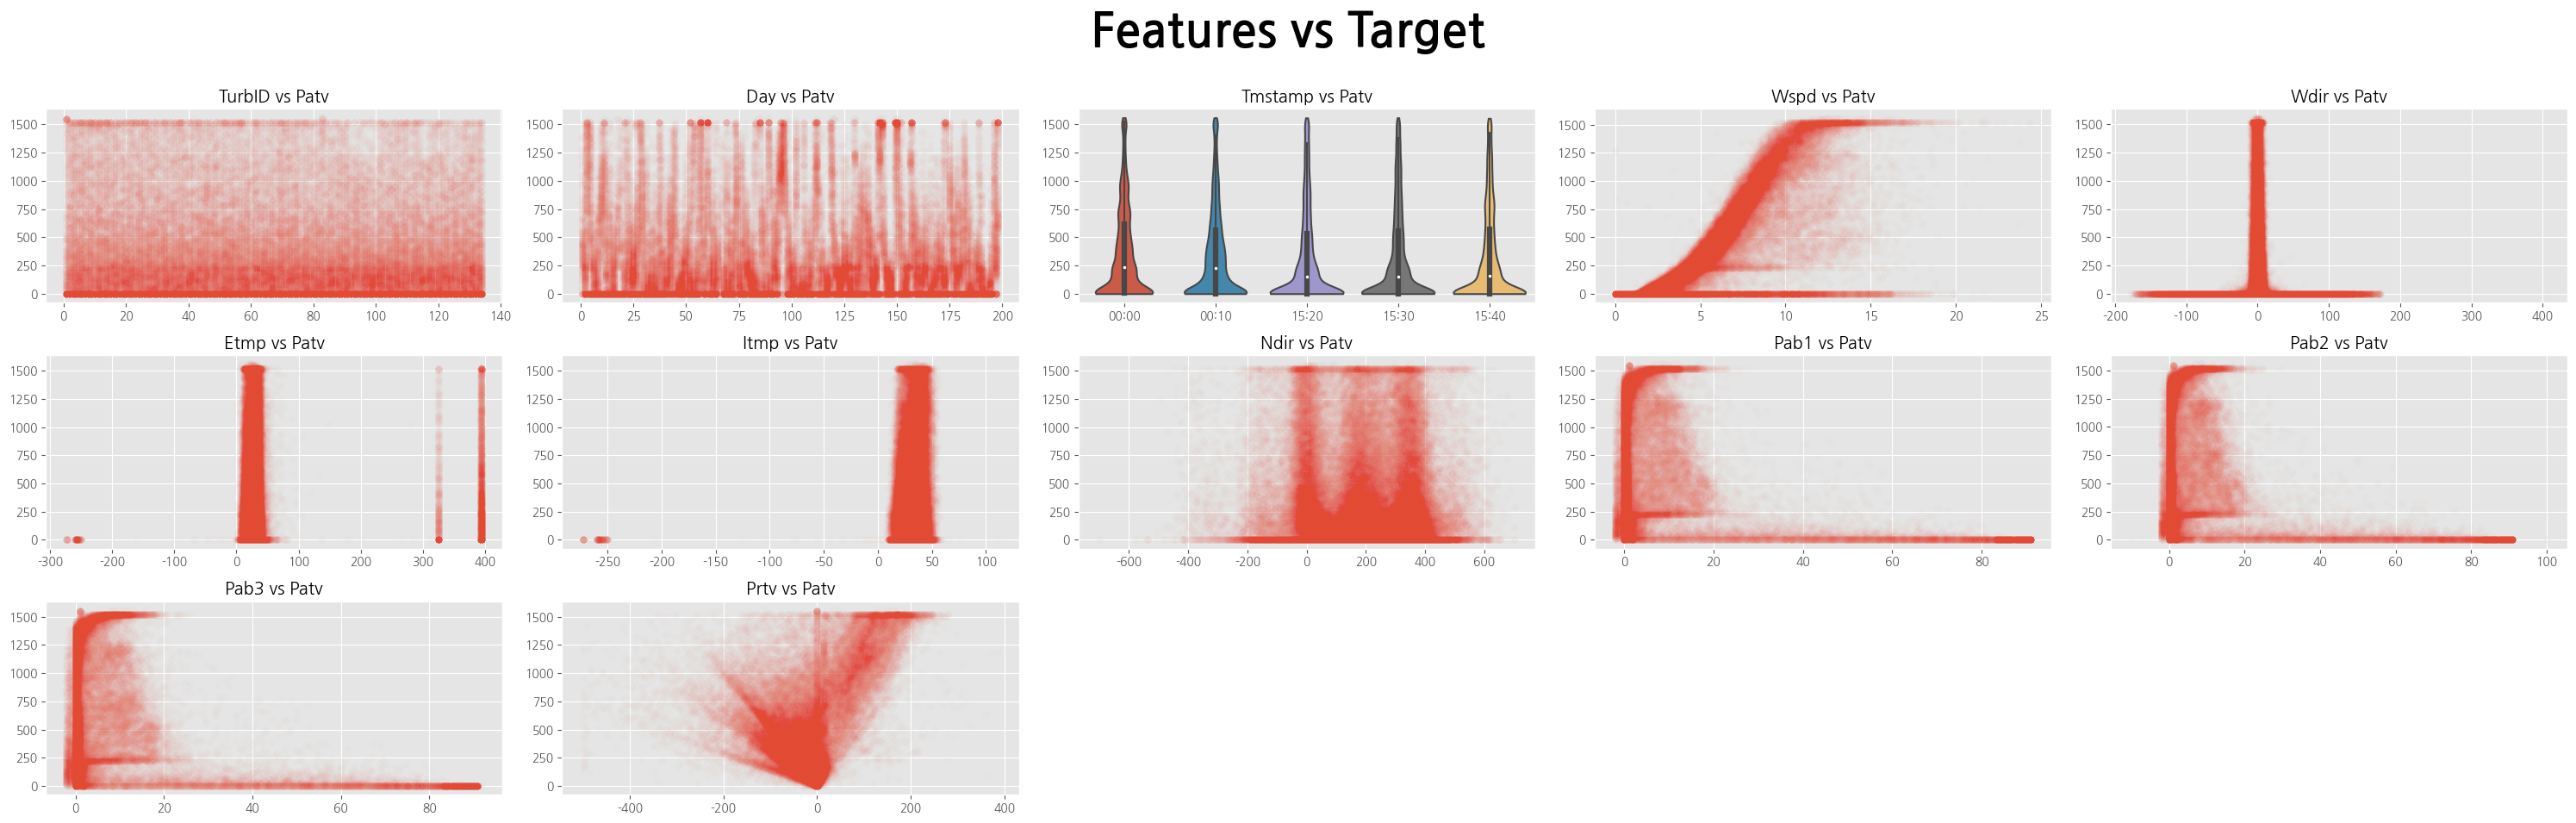

In [8]:
eda.plot_features_target(train, 'Patv', alpha=0.01)

- Day, Etmp, Itmp, Tmstamp, TurbID : 뚜렷한 관계가 보이지 않음
<br></br>
- Etmp, Itmp : outlier 처리 필요
<br></br>
- Ndir : 0, 180, 360 부근에서 발전량이 커짐
<br></br>
- Wdir : 절댓값이 10 이상 넘어가면 발전량이 거의 없음
<br></br>
- Pab1, Pab2, Pab3 : 거의 동일한 plot을 보임(0도에 가까울 때, 발전량이 나타남)
<br></br>
- Prtv : Prtv가 음수일 때는 Patv와 음의 상관관계, 양수일 경우는 양의 상관관계를 가지는 것이 보임
<br></br>
- Wspd : Patv와 강한 양의 상관관계를 보임

# 5. Plot time-series features

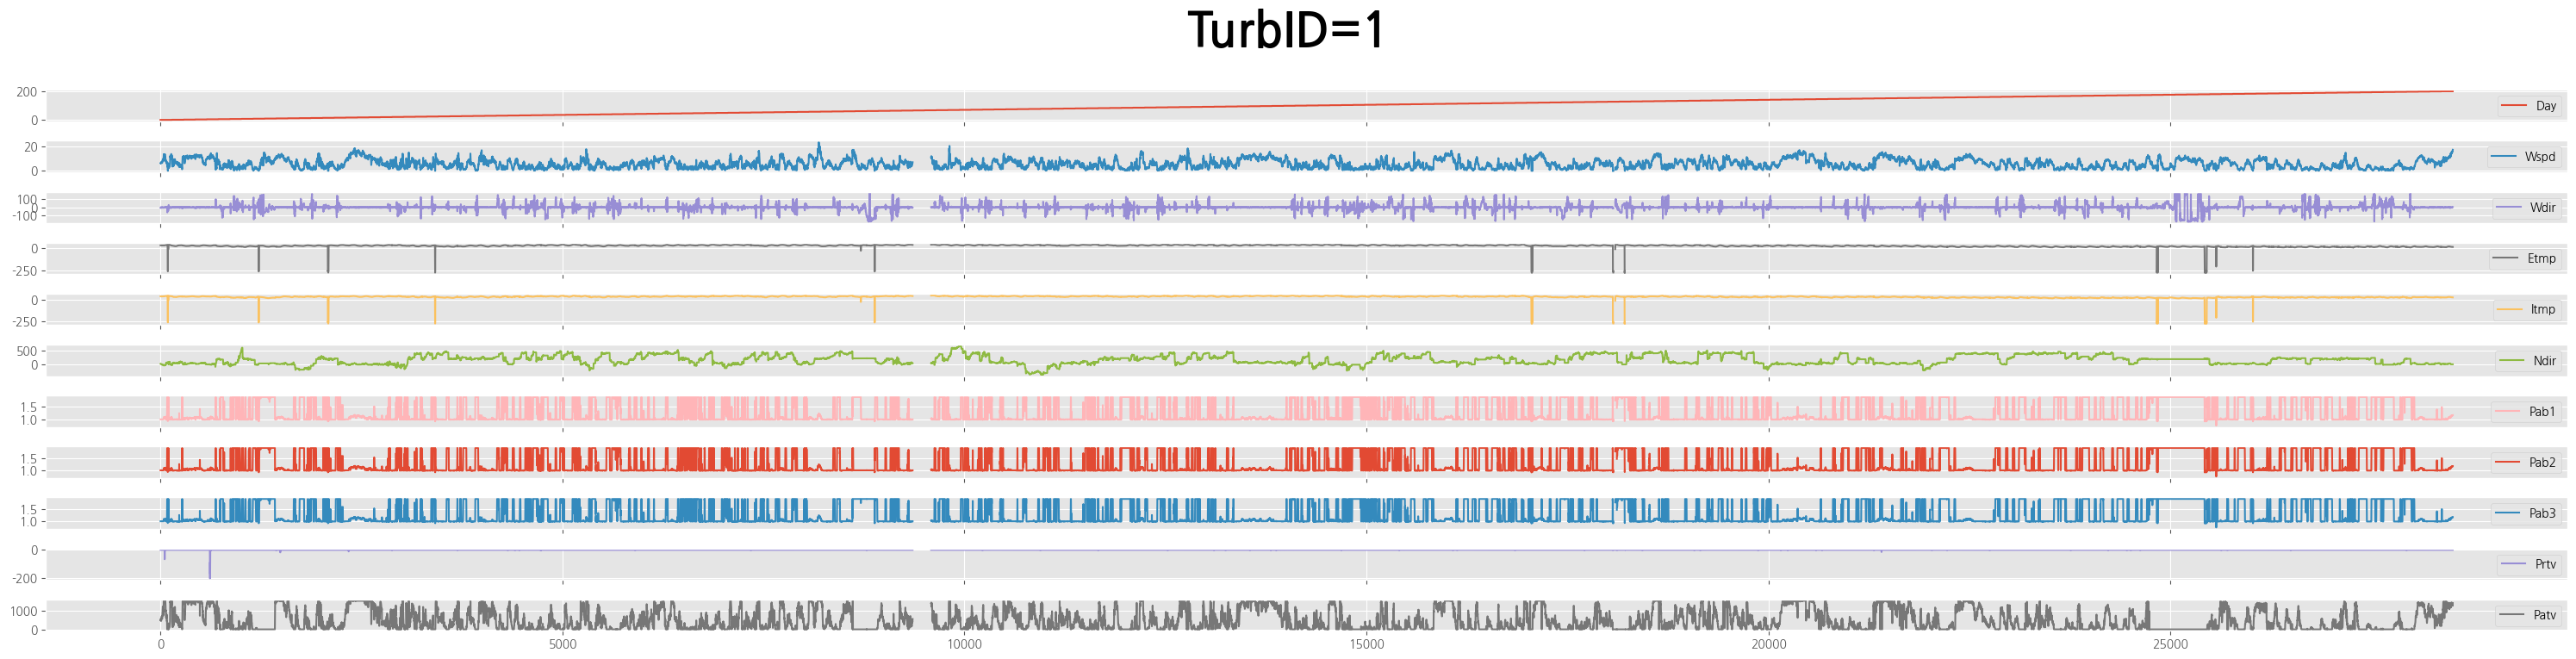

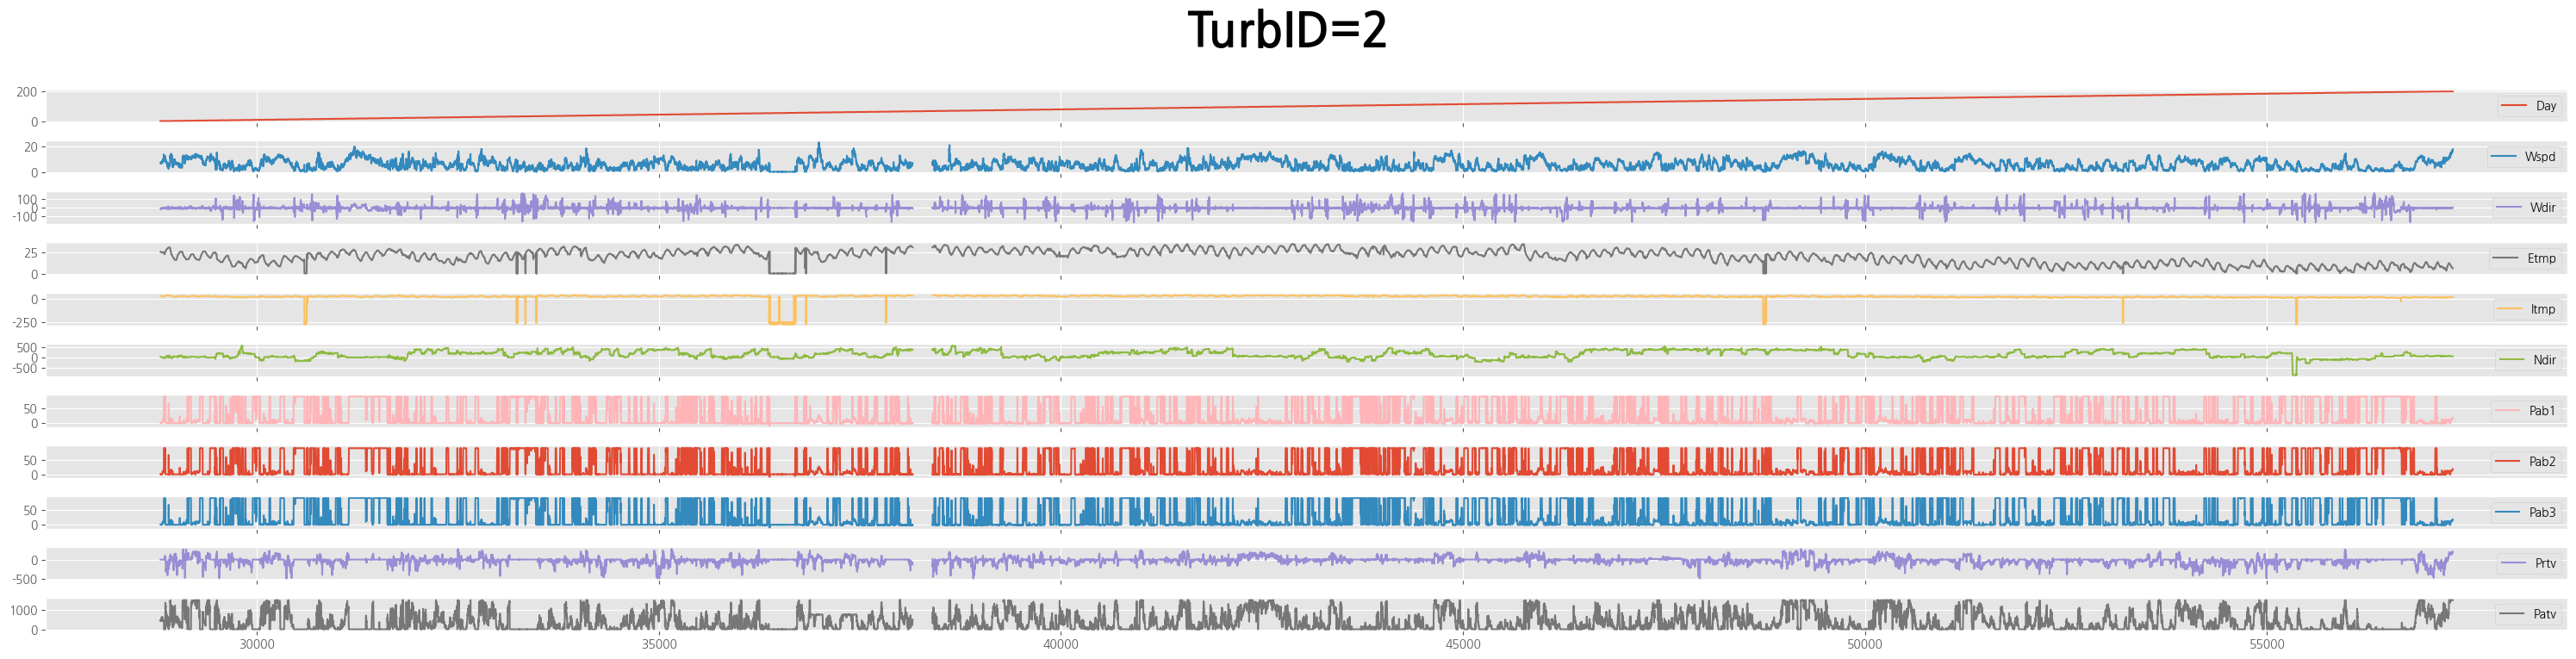

In [9]:
eda.plot_ts_features(train.query("TurbID == 1").drop(columns=['TurbID']), title='TurbID=1', figsize=(30, 8))
eda.plot_ts_features(train.query("TurbID == 2").drop(columns=['TurbID']), title='TurbID=2', figsize=(30, 8))

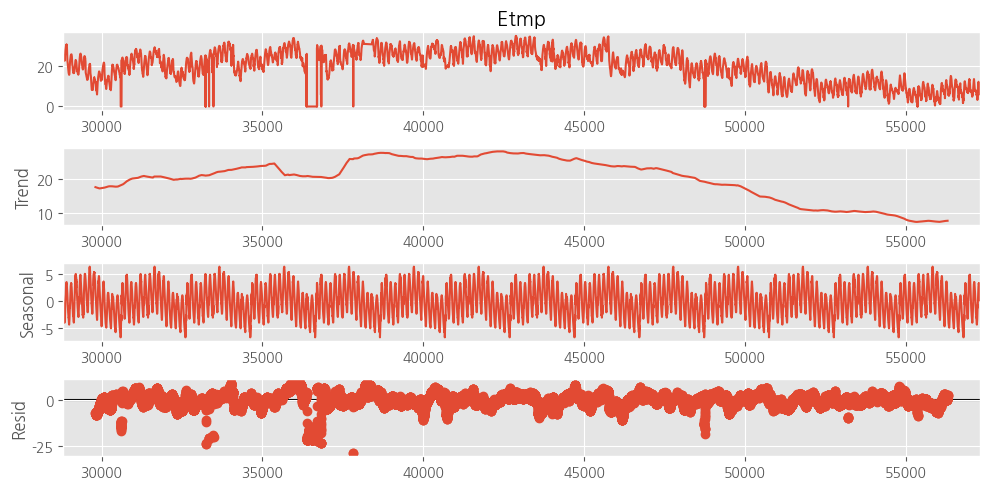

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

d = train[train['TurbID'] == 2]
d['Etmp'] = d['Etmp'].interpolate().ffill().bfill()
ts = d.Etmp
result = seasonal_decompose(ts, model='additive', period=14*144)  # 7 days

plt.rcParams['figure.figsize'] = [10, 5]
result.plot()
plt.show()

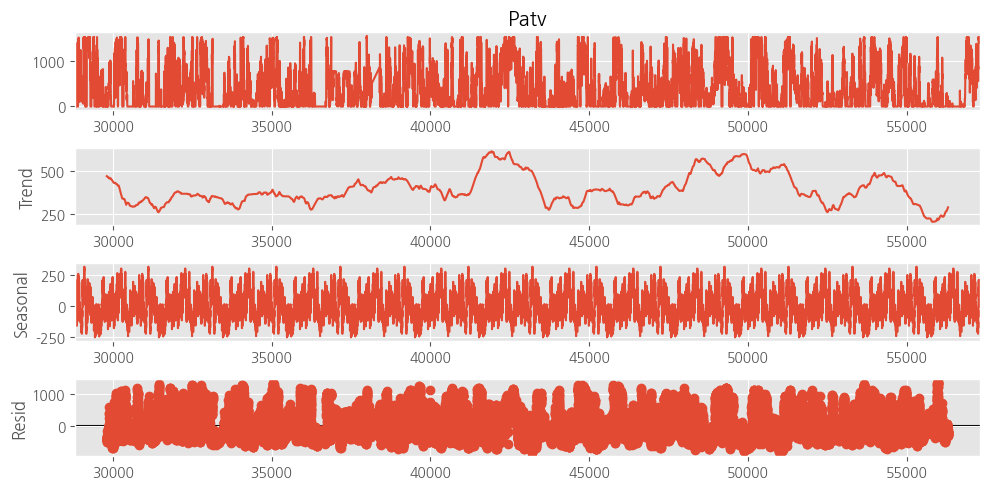

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

d = train[train['TurbID'] == 2]
d['Patv'] = d['Patv'].interpolate().ffill().bfill()
ts = d.Patv.iloc[1:]
result = seasonal_decompose(ts, model='additive', period=14*144)  # 7 days

plt.rcParams['figure.figsize'] = [10, 5]
result.plot()
plt.show()

- feature를 time-series로 plot했을 때, 같은 시점에 서로 반비례하는 관계를 보이는 feature들이 보임(Patv VS Pab1, Pab2, Pab3)
- 사이사이 outlier를 가진 feature들이 보임(Etmp, Itmp, Ndir)
- seasonality가 보이는 feature들이 있음(Wspd, Etmp, Itmp, Ndir)

# 6. Correlation Analysis

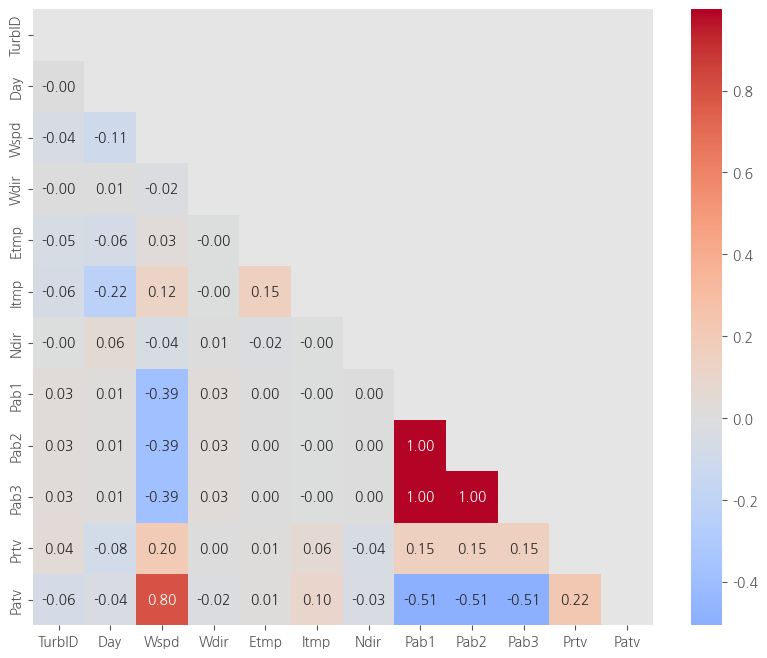

In [12]:
Title = "Correlation matrix"

figsize = (10, 8)

fig, ax = plt.subplots(figsize=figsize)

mask_mat = np.eye(len(train.corr()), dtype=bool)
mask_mat[np.triu_indices_from(mask_mat, k=1)] = True
sns.heatmap(train.corr(), mask=mask_mat, ax=ax, annot=True, fmt=".2f", cmap='coolwarm', center=0)

ax.set_xlabel(None), ax.set_ylabel(None);

- Wspd(풍속)의 경우 확실히 Patv(발전량)과의 Correlation이 높은 것을 알 수 있으며, 이는 경험적 사실과도 일치
- Pab(터빈의 날개 각도) feature끼리는 Correlation이 1인 것을 볼 수 있음
- 이외에 특별히 눈에 띄는 Correlation은 보이지 않음

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_acfs(data, cols=None, lags=144*30+1):
    if cols is None:
        cols = data.columns
    acfs = {}
    fig, axes = plt.subplots(len(cols), figsize=(40, len(cols)*2))
    for ax, col in zip(axes.flat, cols):
        plot_acf(data[col], lags=lags, missing='drop', auto_ylims=True, ax=ax, title=col)
        xticks      = np.arange(0, lags, 144)
        xticklabels = [f"{xtick//144} {'day' if xtick<=144 else 'days'}" for xtick in xticks]
        ax.set_xticks(xticks, xticklabels)
        ax.set_ylim([-1, 1])
        ax.set_xlim([-1, lags+1])

        _, line2 = ax.lines
        acf = line2.get_ydata()[144*2:]
        sorted_acf = np.array(sorted(enumerate(acf), key=lambda x: abs(x[1]), reverse=True), dtype='float32')
        sorted_acf[:, 0] += 144*2
        acfs[col] = sorted_acf
        
        acf, _ = acfs[col][0]
        ax.axvline(acf, color='k')
    for ax in axes.flat[:-1]:
        ax.set_xticklabels([])
    
    return acfs

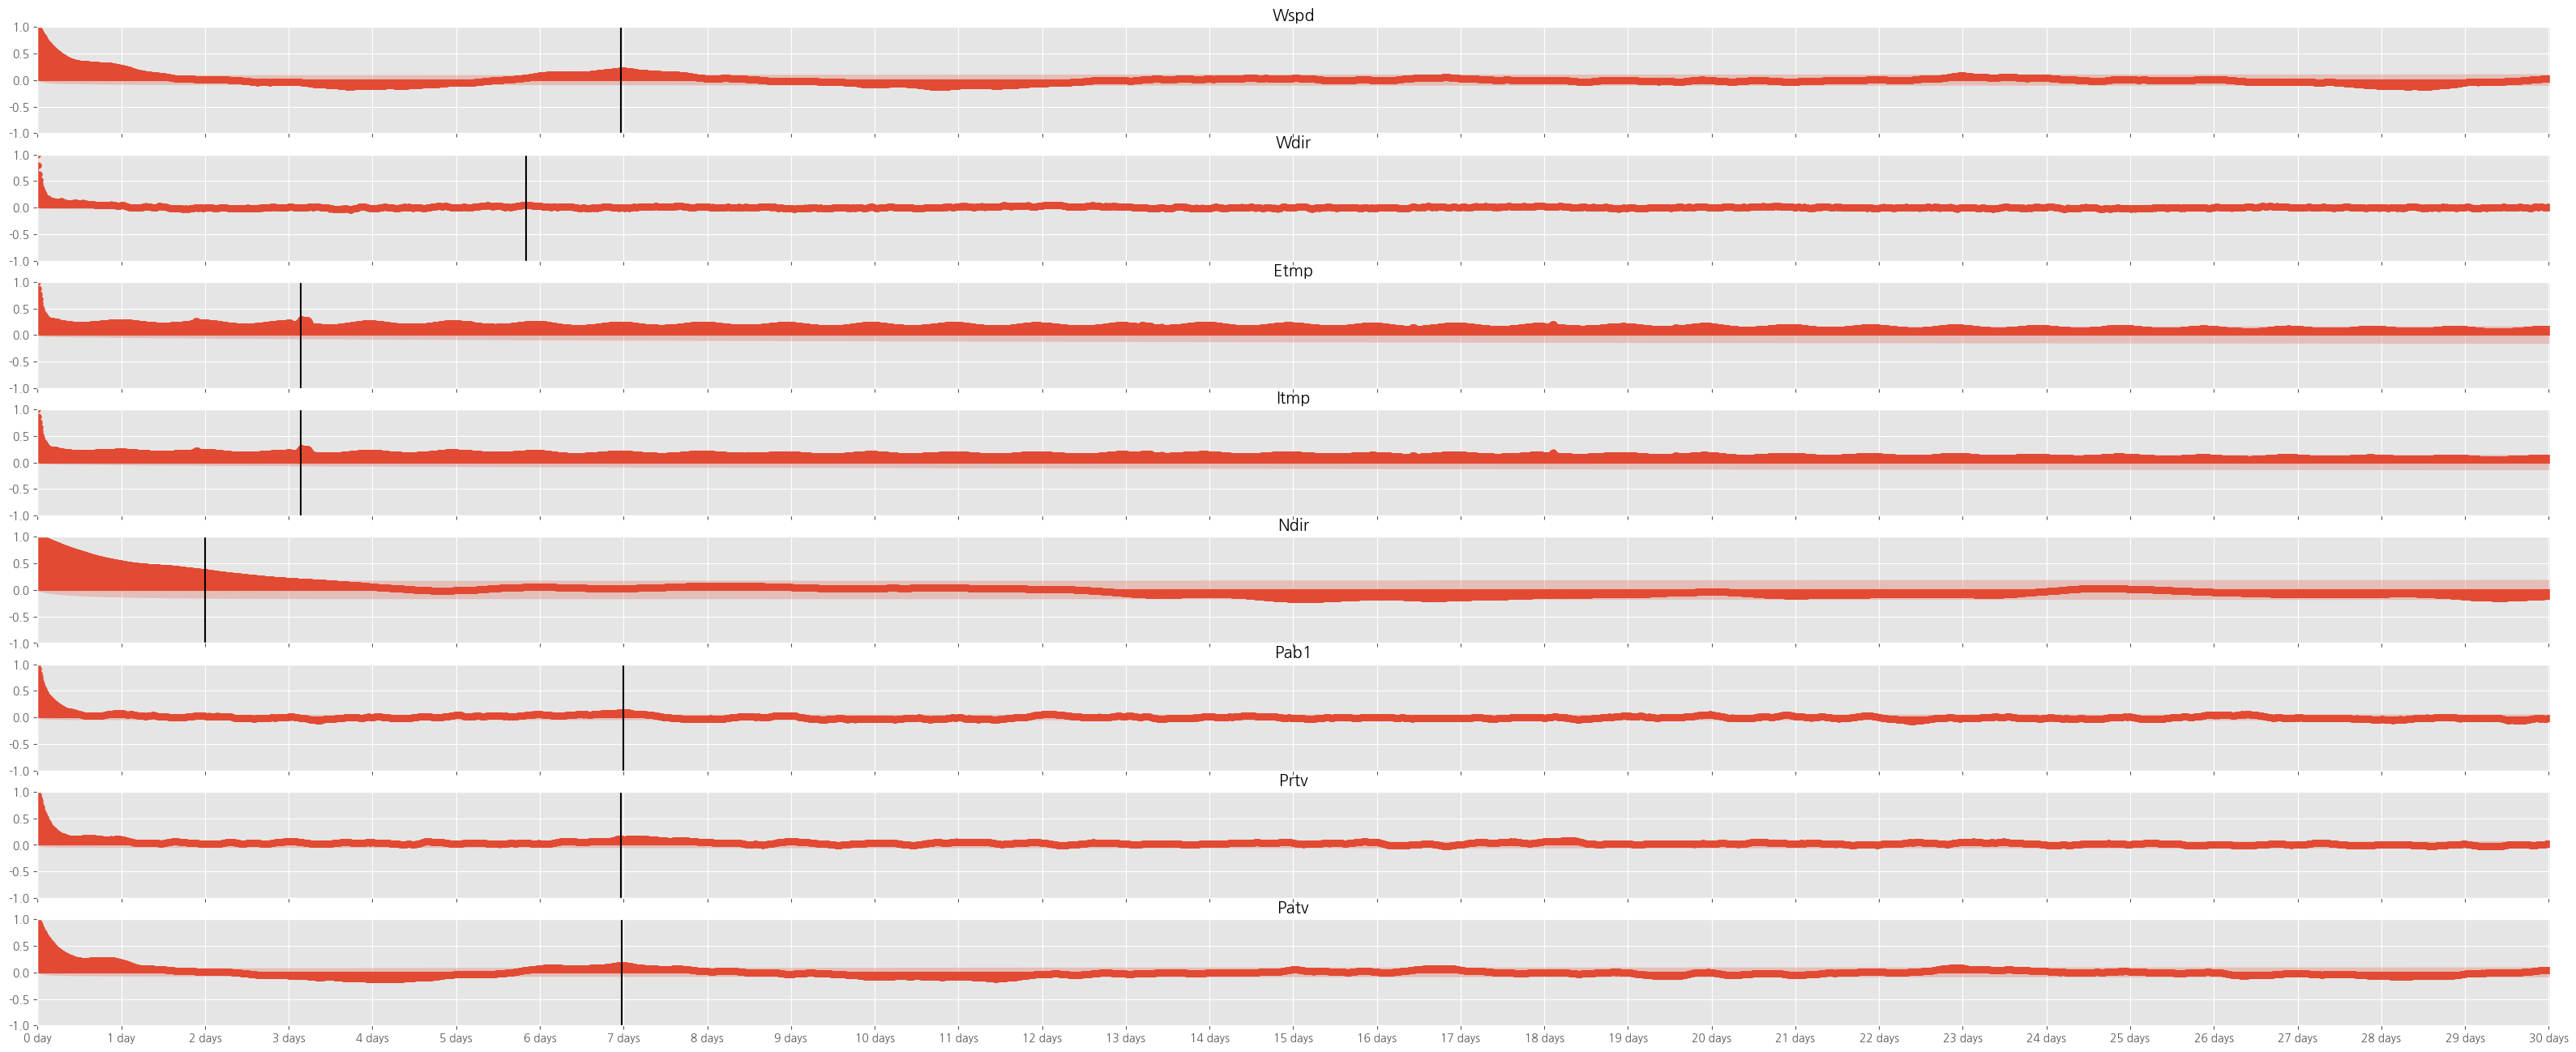

In [14]:
acfs = plot_acfs(train.query("TurbID == 10"), cols=['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Prtv', 'Patv'])

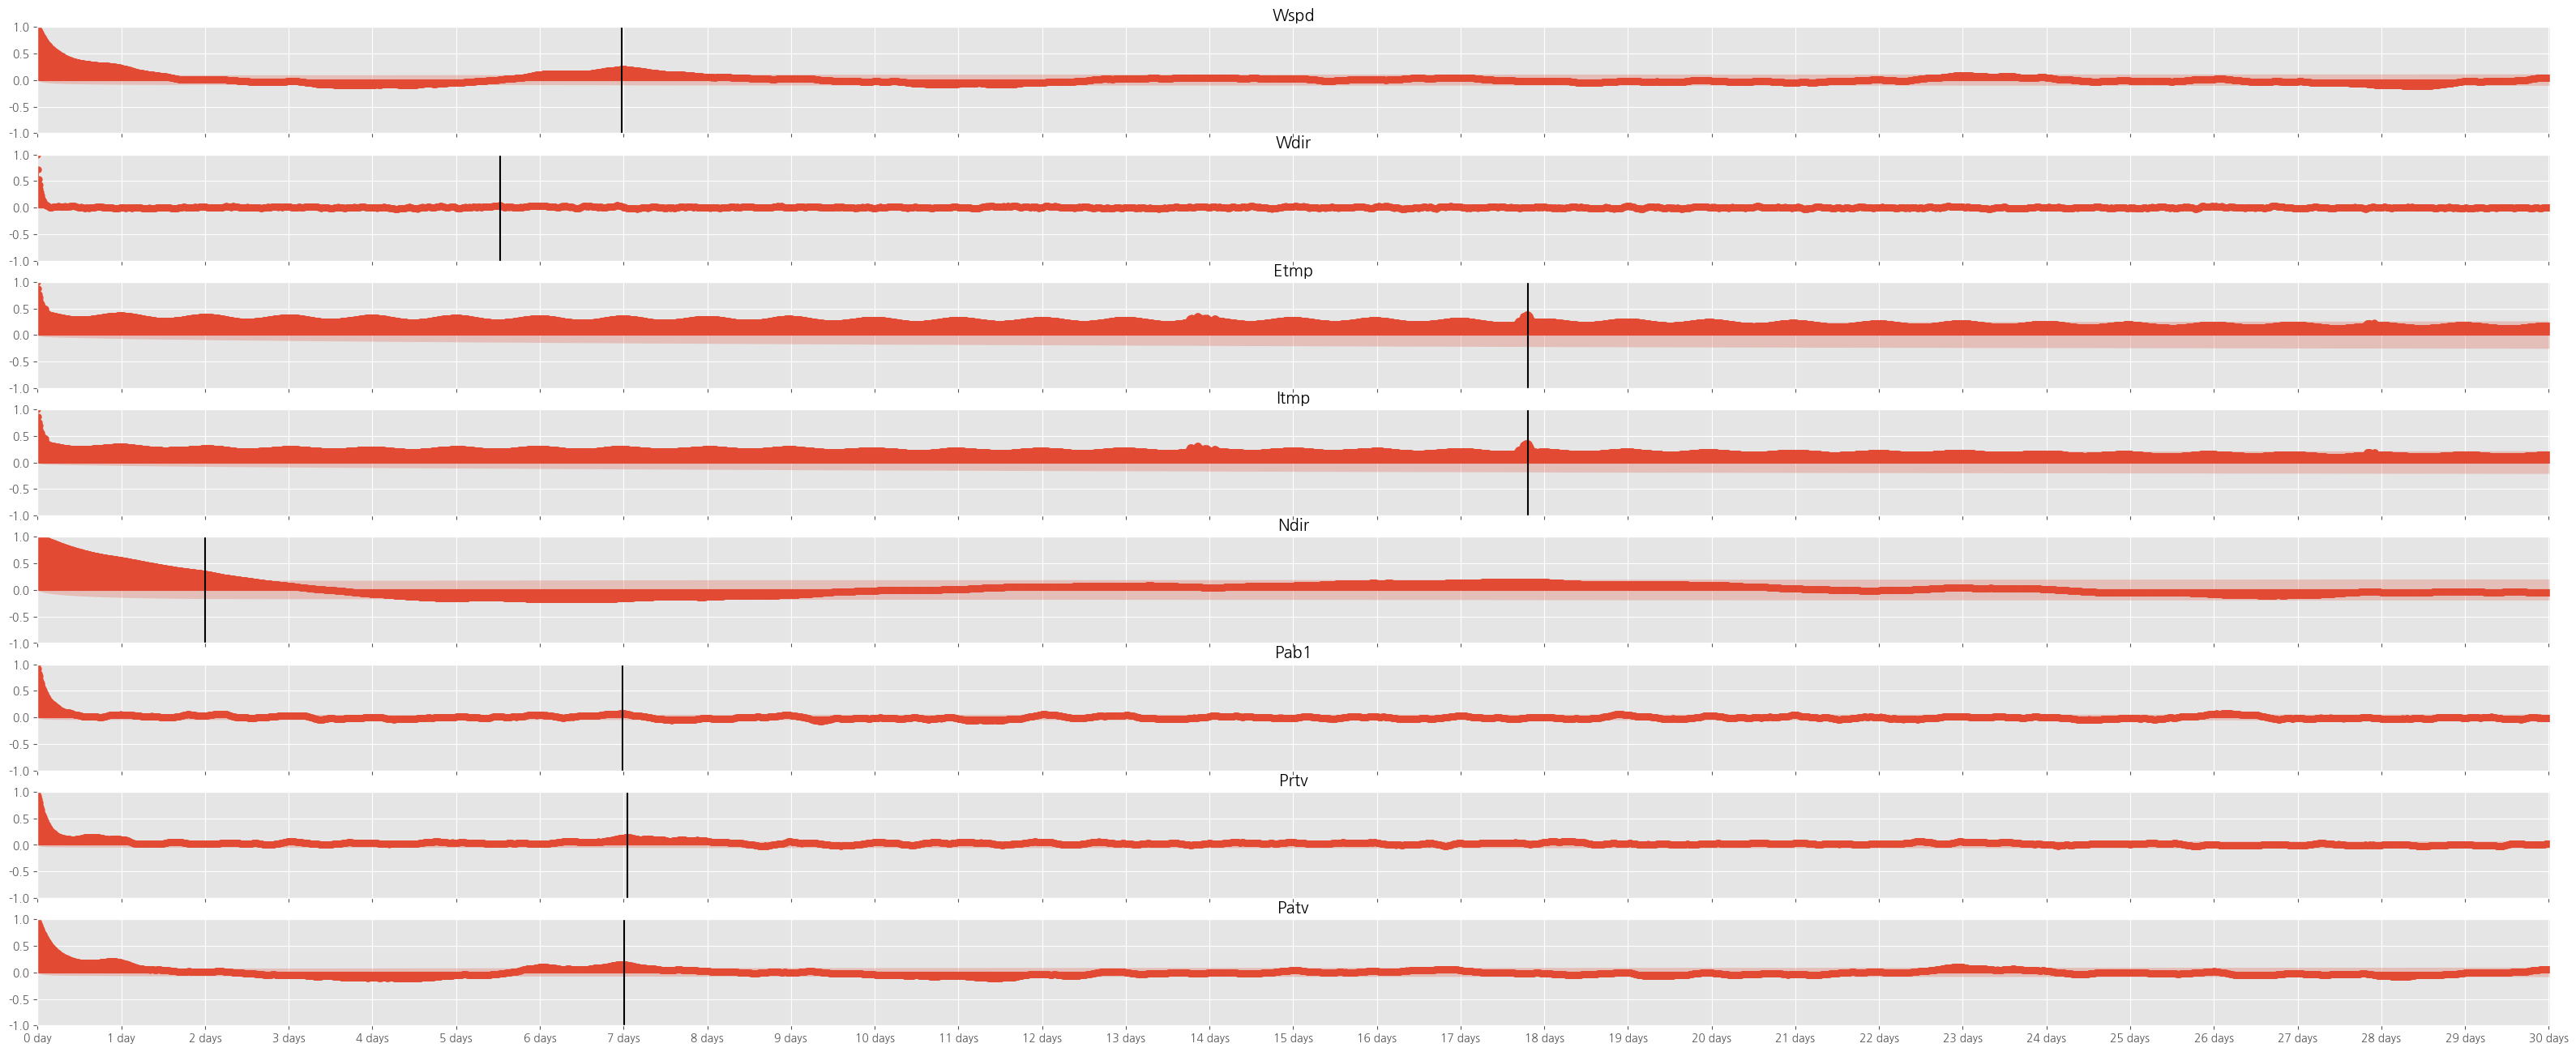

In [15]:
acfs = plot_acfs(train.query("TurbID == 20"), cols=['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Prtv', 'Patv'])

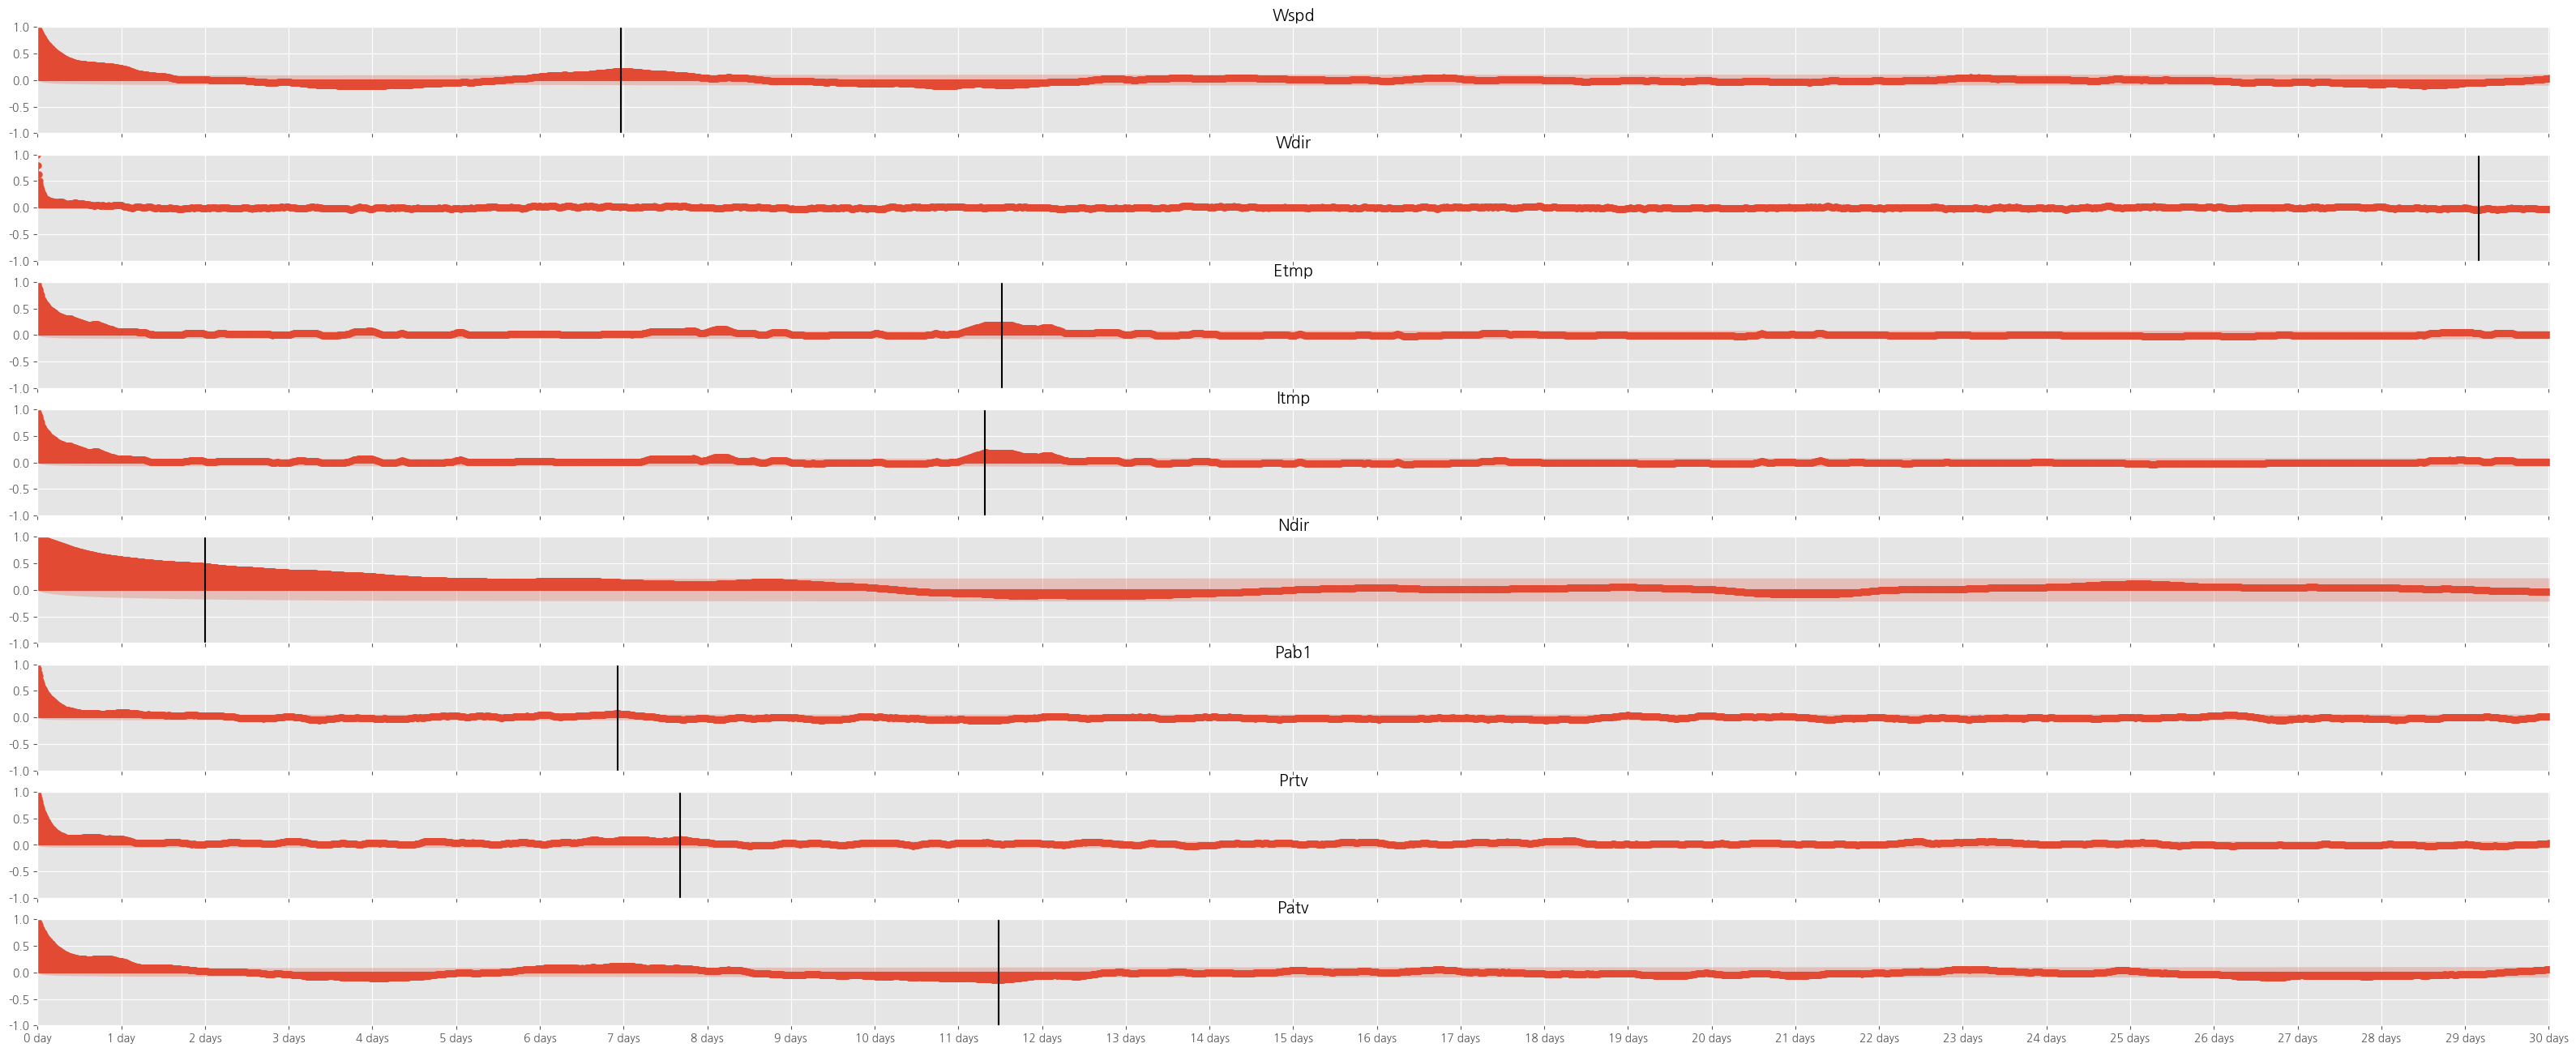

In [16]:
acfs = plot_acfs(train.query("TurbID == 30"), cols=['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Prtv', 'Patv'])

- Autocorrelation을 plot해본 결과 7일째에 가장 큰 값이 나오는 feature들이 많았음